In [1]:
###======= Imports =======###
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from alpha_vantage.timeseries import TimeSeries 
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from CustomRWKV import RwkvConfig, RwkvModel, RwkvPreTrainedModel
from rwkv.model import RWKV
import math


c:\Users\Latzres\Anaconda3\envs\deep_proj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number data points 5941 from 1999-11-01 to 2023-06-12


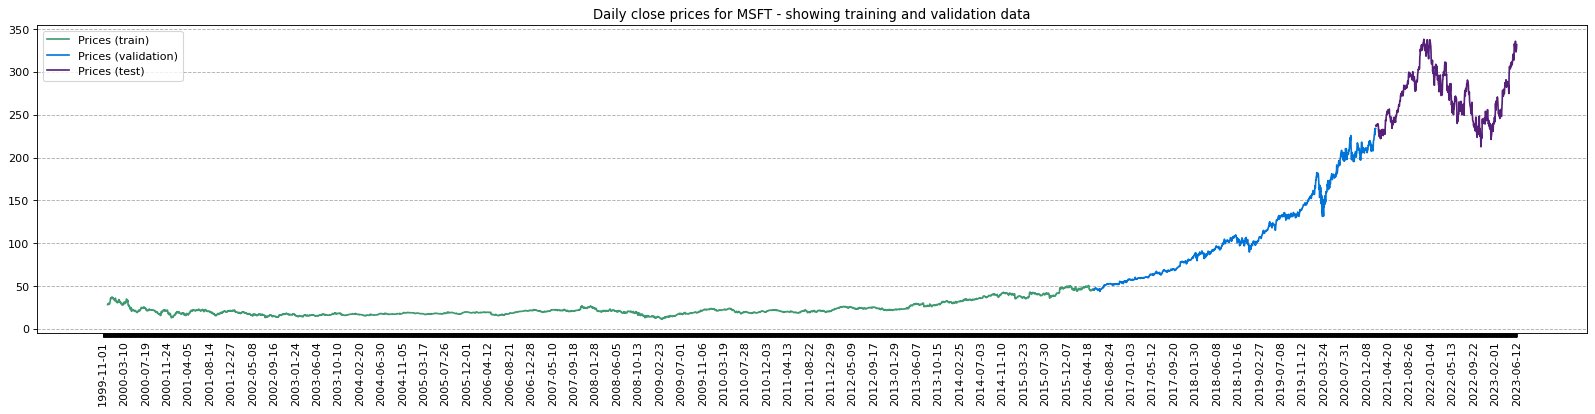

Train data shape (4144, 20, 1) (4144,)
Validation data shape (1184, 20, 1) (1184,)
Test data shape (593, 20, 1) (593,)


In [2]:
import Utils
# Get dataloaders from our Utils file
train_loader, val_loader, test_loader = Utils.run()

In [3]:
# Define Transformer Model
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5, norm_first=False):
        super(TransformerModel, self).__init__()
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout, norm_first=norm_first)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

In [4]:
# instantiate Transformer model
transformer_model = TransformerModel(ntoken=int(20e3), ninp=220, nhead=2, nhid=220, nlayers=4, dropout=0.2, norm_first=True)

In [5]:
# Define RWKV model
rwkv_config = RwkvConfig(vocab_size=2000, context_length=256, hidden_size=20, num_hidden_layers=8)
rwkv_model = RwkvModel(rwkv_config)

In [6]:
epochs = 20
criterion = nn.MSELoss()
optimizer = torch.optim.RAdam(transformer_model.parameters(), lr=2.5e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
model = rwkv_model
model.to(device)

RwkvModel(
  (blocks): ModuleList(
    (0): RwkvBlock(
      (pre_ln): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (ln1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (attention): RwkvSelfAttention(
        (time_shift): ZeroPad2d((0, 0, 1, -1))
        (key): Linear(in_features=20, out_features=20, bias=False)
        (value): Linear(in_features=20, out_features=20, bias=False)
        (receptance): Linear(in_features=20, out_features=20, bias=False)
        (output): Linear(in_features=20, out_features=20, bias=False)
      )
      (feed_forward): RwkvFeedForward(
        (time_shift): ZeroPad2d((0, 0, 1, -1))
        (key): Linear(in_features=20, out_features=80, bias=False)
        (receptance): Linear(in_features=20, out_features=20, bias=False)
        (value): Linear(in_features=80, out_features=20, bias=False)
      )
    )
    (1-7): 7 x RwkvBlock(
      (ln1): LayerNorm((20,), eps=1

In [8]:
def evaluate(data_loader):
    data_iterator = iter(data_loader)
    nb_batches = len(data_loader)
    model.eval()
    acc = 0 
    losses = 0.0
    for _, (x, y) in enumerate(data_iterator):
        x = x.view(x.size(0), x.size(1)).to(device)
        y = y.to(device)
        print(x)
        print(y)
        out = model(x)
        out = out.last_hidden_state.view(x.size(0), x.size(1))[:,-1]
        loss = criterion(out, y.contiguous())
        losses += loss
        
    print(f"eval loss: {losses / nb_batches}")
    

def train(train_loader, valid_loader):
    
    for epoch in range(epochs):
        train_iterator, valid_iterator = iter(train_loader), iter(valid_loader)
        nb_batches_train = len(train_loader)
        train_acc = 0
        model.train()
        losses = 0.0

        for idx, (x, y) in enumerate(train_loader):
            x = x.view(x.size(0), x.size(1)).to(device)
            y = y.to(device)
            # print(x.shape)
            out = model(x)
            out = out.last_hidden_state.view(x.size(0), x.size(1))[:,-1]
            # print(out.shape)
            # print(y.shape)
            loss = criterion(out, y.contiguous())
            
            optimizer.zero_grad()

            loss.backward()
            losses += loss.item()

            optimizer.step()
        
        print(f"epoch {epoch}: train loss: {losses / nb_batches_train}")
        # print(f"training accuracy: {train_acc / nb_batches_train}")
        print('evaluating on validation:')
        evaluate(valid_loader)

In [9]:
train(train_loader, val_loader)

epoch 0: train loss: 1.675530169560359
evaluating on validation:
tensor([[ 0.3649,  0.3766,  0.3682,  ...,  0.4181,  0.4120,  0.4241],
        [-0.2535, -0.2551, -0.2473,  ..., -0.2260, -0.2228, -0.2159],
        [ 0.2512,  0.2503,  0.2561,  ...,  0.2649,  0.2572,  0.2656],
        ...,
        [ 0.8423,  0.8214,  0.8449,  ...,  0.8573,  0.8488,  0.8217],
        [ 0.8011,  0.8316,  0.8418,  ...,  0.8924,  0.8966,  0.9064],
        [ 1.4530,  1.5084,  1.5164,  ...,  1.7567,  1.7490,  1.6700]])
tensor([ 0.4145, -0.2125,  0.2513,  0.0255,  0.2446,  1.3627,  0.1717, -0.1383,
         1.7242, -0.1581, -0.1649, -0.0611,  1.2185,  1.3987, -0.2386,  1.6095,
         1.9709,  2.0745, -0.0273,  0.4492,  1.7953,  1.6320,  0.0164,  0.5775,
        -0.1057,  1.5922,  0.1460,  1.3704, -0.1628, -0.1507,  0.0178,  1.7683,
         0.3362,  0.2309,  1.4210, -0.1193, -0.1012,  0.5404,  0.4540,  0.8458,
         0.2192,  0.4068,  0.7217,  0.8243, -0.0741,  0.2920, -0.0980, -0.1784,
         0.4845,  1.1

RuntimeError: expand(torch.FloatTensor{[64, 20]}, size=[64]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)